<a href="https://colab.research.google.com/github/ravifrancesco/ECG_Heartbeat_Classification/blob/dblstm-ws-mit/DBLSTM-WS_mit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook parameters

In [1]:
use_tpu = False
train = False

1) Checking resources

In [2]:
if use_tpu:
  %tensorflow_version 2.x
  import tensorflow as tf
  print("Tensorflow version " + tf.__version__)

  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


2) Setting up colab

In [4]:
# Gloabal variables
data_path = "/content/gdrive/My Drive/ETH/MLH/Project1/data/"
model_path = "/content/gdrive/My Drive/ETH/MLH/Project1/model/"

random_seed = 50

In [5]:
# Mount Google Drive and set data paths.
import os
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


3) Imports

In [6]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

import pywt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, optimizers, losses
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5402172461934763113
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15613737575087949557
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Default GPU Device: /device:GPU:0


4) Loading data

In [8]:
df_train = pd.read_csv(data_path + "input/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv(data_path + "input/mitbih_test.csv", header=None)

Y_train = np.array(df_train[187].values).astype(np.int8)
Y_train = tf.keras.utils.to_categorical(Y_train)
X_train = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
Y_test = tf.keras.utils.to_categorical(Y_test)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

print("X_train shape is {}".format(X_train.shape))
print("Y_train shape is {}".format(Y_train.shape))
print("X_test shape is {}".format(X_test.shape))
print("Y_test shape is {}".format(Y_test.shape))

X_train shape is (87554, 187, 1)
Y_train shape is (87554, 5)
X_test shape is (21892, 187, 1)
Y_test shape is (21892, 5)


In [9]:
X_train = np.squeeze(X_train)
Y_train = np.squeeze(Y_train)
X_test = np.squeeze(X_test)
Y_test = np.squeeze(Y_test)

print("X_train shape is {}".format(X_train.shape))
print("Y_train shape is {}".format(Y_train.shape))
print("X_test shape is {}".format(X_test.shape))
print("Y_test shape is {}".format(Y_test.shape))

X_train shape is (87554, 187)
Y_train shape is (87554, 5)
X_test shape is (21892, 187)
Y_test shape is (21892, 5)


5) Visualizing data

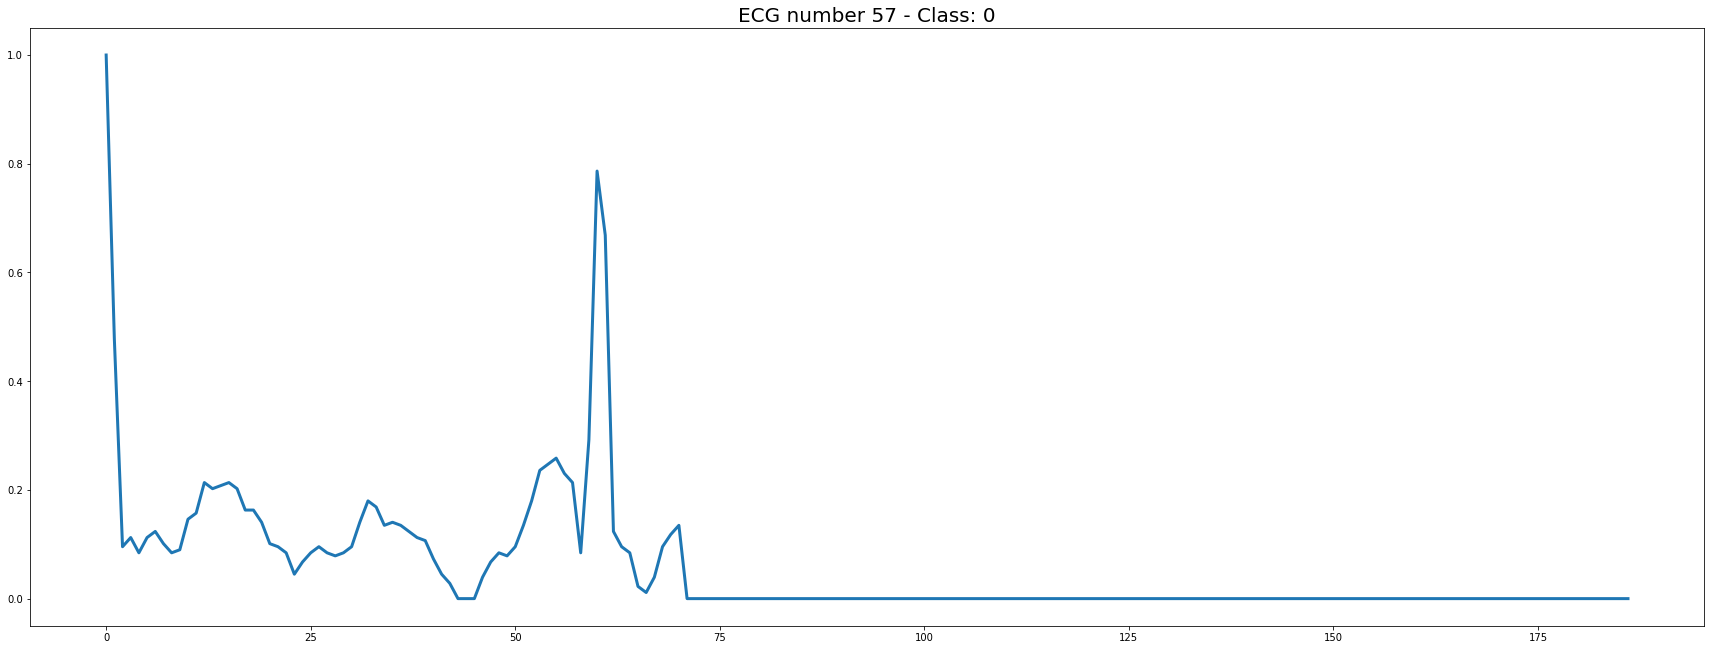

In [10]:
# Plotting one signal
example_signal = 56
plt.rcParams['lines.linewidth'] = 3
plt.figure(figsize=(30, 11))
plt.plot(X_train[example_signal])
plt.title("ECG number {} - Class: {}".format(example_signal+1, np.argmax(Y_train[example_signal])), size = 20)
plt.show()


6) Building SimpleRNN

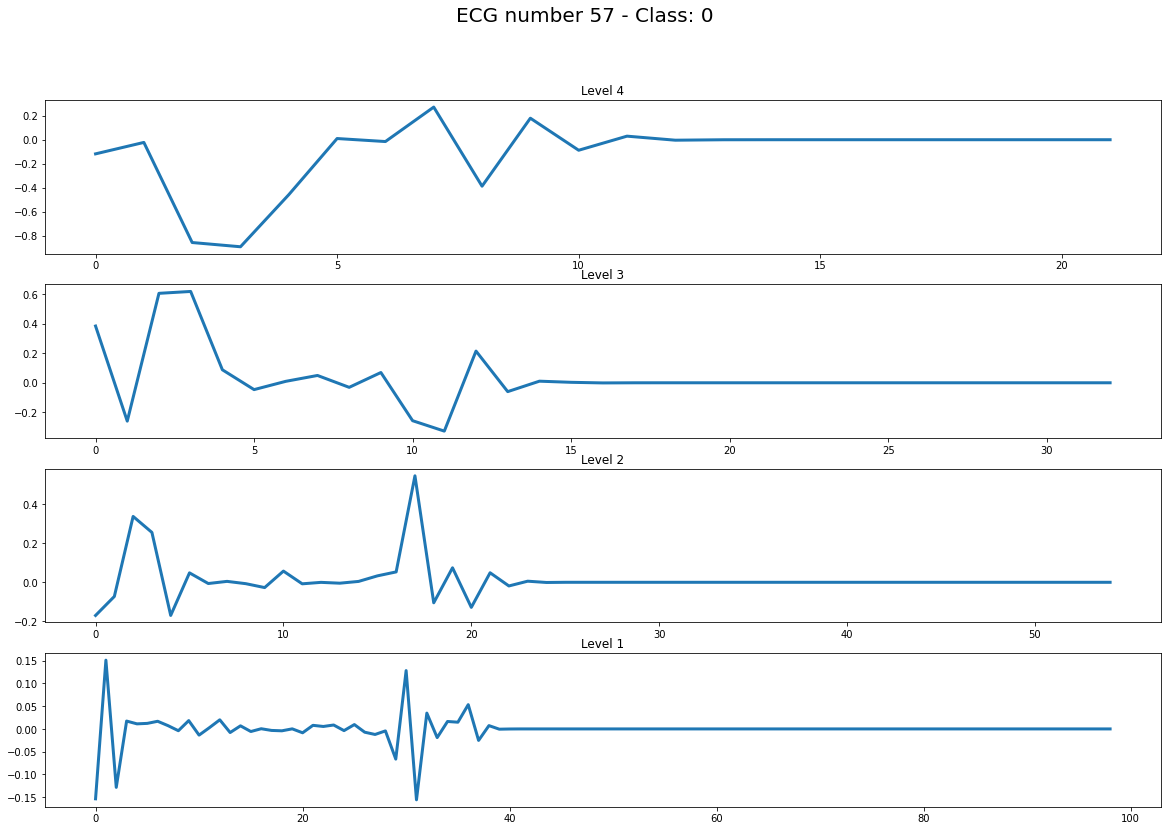

In [11]:
# Discrete wavelet transform multiresolution analysis level by level
coeffs = pywt.wavedec(X_train[example_signal].flatten(), 'db6', mode='symmetric', level=4)[1:]

fig, axs = plt.subplots(4, figsize=(20, 13))
fig.suptitle("ECG number {} - Class: {}".format(example_signal+1, np.argmax(Y_train[example_signal])), size=20)
for i, c in enumerate(coeffs):
  axs[i].plot(c)
  axs[i].set_title("Level {}".format(str(4-i)))

In [12]:
def DWT(signal, levels):
  coeffs = pywt.wavedec(signal.flatten(), 'db6', mode='symmetric', level=levels)[1:]
  coeffs = [np.pad(np.array(c), (0, 187-len(c))) for c in coeffs]
  coeffs += [signal]
  return np.stack(coeffs, axis=-1)

def WSpreprocess(dataset, levels):
  return np.squeeze(np.apply_along_axis(DWT, 1, dataset, levels))

In [13]:
X_train = WSpreprocess(X_train, 2)
#X_val = WSpreprocess(X_val, 2)
X_test = WSpreprocess(X_test, 2)

print("X_train shape is {}".format(X_train.shape))
#print("X_val shape is {}".format(X_val.shape))
print("X_test shape is {}".format(X_test.shape))

X_train shape is (87554, 187, 3)
X_test shape is (21892, 187, 3)


In [14]:
def getDBLSTMWS(input_shape, lr=0.0005, n_classes=5):

  inp = Input(shape=input_shape)
  img_1 = Bidirectional(LSTM(64, return_sequences=True))(inp)
  img_2 = Dropout(0.01)(img_1)
  img_3 = Bidirectional(LSTM(32, return_sequences=True))(img_2)
  img_4 = Dropout(0.01)(img_3)
  img_5 = Flatten()(img_4)
  img_6 = Dense(128, activation='relu')(img_5)
  img_7 = Dropout(0.3)(img_6)
  out = Dense(n_classes, activation='softmax')(img_7)

  model = models.Model(inputs=inp, outputs=out)
  opt = optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt, loss=losses.categorical_crossentropy,
                  metrics=['acc'])
  return model

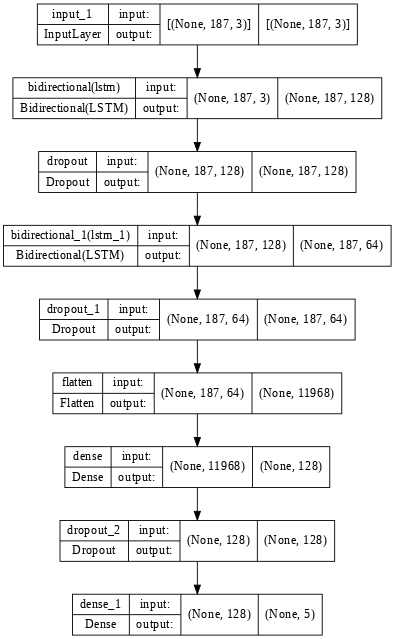

In [15]:
if use_tpu:
  with tpu_strategy.scope():
    sRNN = getDBLSTMWS(X_train[0].shape, lr=0.001)
else:
    sRNN = getDBLSTMWS(X_train[0].shape, lr=0.001)
    
tf.keras.utils.plot_model(sRNN, show_shapes=True, dpi=64)

In [16]:
# Preparing the model
sRNN_file_path = model_path + "DBLSTM-WS_mit.h5"
checkpoint = ModelCheckpoint(sRNN_file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode="min", patience=10, verbose=1)
redonplat = ReduceLROnPlateau(monitor='val_loss', mode="min", patience=5, verbose=2)
callbacks_list = [early, checkpoint, redonplat]

In [17]:
# Fitting the model
if train:
  history = sRNN.fit(X_train, Y_train, epochs=1000, verbose=2, callbacks=callbacks_list, batch_size=128, validation_split=0.2)

Epoch 1/1000

Epoch 1: val_loss improved from inf to 0.16007, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/DBLSTM-WS.h5
548/548 - 32s - loss: 0.2943 - acc: 0.9206 - val_loss: 0.1601 - val_acc: 0.9613 - lr: 0.0010 - 32s/epoch - 58ms/step
Epoch 2/1000

Epoch 2: val_loss improved from 0.16007 to 0.11132, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/DBLSTM-WS.h5
548/548 - 22s - loss: 0.1494 - acc: 0.9604 - val_loss: 0.1113 - val_acc: 0.9705 - lr: 0.0010 - 22s/epoch - 41ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 0.11132 to 0.10272, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/DBLSTM-WS.h5
548/548 - 22s - loss: 0.1162 - acc: 0.9679 - val_loss: 0.1027 - val_acc: 0.9719 - lr: 0.0010 - 22s/epoch - 40ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 0.10272 to 0.08696, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/DBLSTM-WS.h5
548/548 - 22s - loss: 0.0965 - acc: 0.9728 - val_loss: 0.0870 - val_acc: 0.9766 -

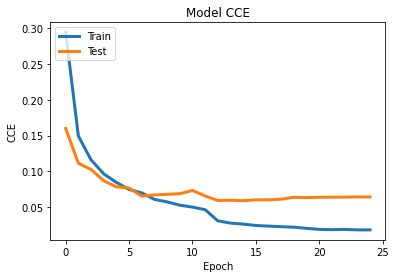

In [18]:
# Plot training & validation loss values
if train:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model CCE')
    plt.ylabel('CCE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

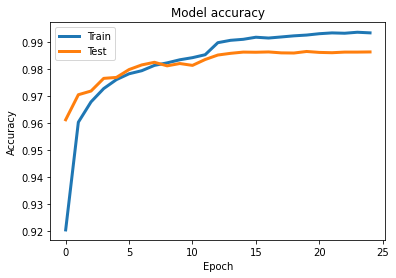

In [19]:
# Plot training & validation accuracy values
if train:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [20]:
# Analysis of the model
sRNN.load_weights(sRNN_file_path)
Y_pred_test = sRNN.predict(X_test)
cce = tf.keras.losses.CategoricalCrossentropy()
print("Model CCE: {}".format(cce(Y_test,Y_pred_test).numpy()))
m = tf.keras.metrics.Accuracy()
m.update_state(np.argmax(Y_test,axis=1), np.argmax(Y_pred_test,axis=1))
print("Model accuracy: {}".format(m.result().numpy()))

Model CCE: 0.07176744192838669
Model accuracy: 0.9852457642555237


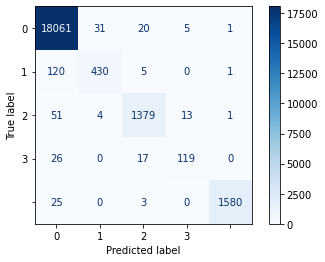

In [21]:
# Plotting confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_test, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])

disp.plot(cmap=plt.cm.Blues)
plt.show()